# Deep ALM Showcase

## Problem Description

### Market Price Dynamics
The returns of assets and liabilities follow a **Geometric Brownian Motion (GBM)**
$$
\begin{aligned}
dS_{A,t}^i&=\mu_I^iS_{A,t}^idt+\sigma_I^iS_{A,t}^idW_{A,t}^i,\qquad i=1,2,\dots,n,\quad t=1,2,\dots,T,\\
dS_{L,t}&=\mu_LS_{L,t}dt+\sigma_LS_{L,t}dW_{L,t},
\end{aligned}
$$
where
- $S_{A,t}^i$ is the price of asset $i$ at time $t$, $S_{L,t}$ is the liability amount at time $t$,
- $\mu_I^i$ and $\mu_L$ are the **drift terms** for assets and liabilities respectively,
- $\sigma_I^i$ and $\sigma_L$ are the **volatilities**,
- $dW_{A,t}^i$ and $dW_{L,t}$ are independent **Brownian motions**.

### Balance Sheet Restructuring
The investments portfolio is restructured from «pre» to «post» subject to the constraint
$$\left(\sum_{i=1}^n x_{A,t}^{i,\text{post}}\right)+c_t^\text{post}=\left(\sum_{i=1}^n x_{A,t}^{i,\text{pre}}\right)+c_t^\text{pre}+d_t,$$
where
- $x_{A,t}^{i,\cdot}$ is the allocation to asset $i$ at time $t$,
- $c_t^{\cdot}$ is the cash holding at time $t$,
- $d_t$ is the new debt issuance at time $t$.

### Balance Sheet Roll-Forward

#### Assets Evolution
The asset components at time $t+1$ are
$$
\begin{aligned}
c_{t+1}^\text{pre}&=c_t^\text{post}(1+r_c),\\
\sum_{i=1}^{n}x_{A,t+1}^{i,\text{pre}}&=\sum_{i=1}^{n}x_{A,t}^{i,\text{post}}\frac{S_{A,t+1}^i}{S_{A,t}^i}.
\end{aligned}
$$
where
- the upper relation accounts for the **growth of assets** through stochastic market returns,
- the lower relation accounts for the **cash balance accumulation**.

The total assets at time $t$ with the superscripts «pre» and «post» are given by
$$A_t^\cdot=\left(\sum_{i=1}^n x_{A,t}^{i,\cdot}\right)+c_t^\cdot.$$

#### Liabilities Evolution
Similarly, the liabilities evolve as
$$
\begin{aligned}
L_t^\text{post}&=L_t^\text{pre}+d_t\\
L_{t+1}^\text{pre}&=L_t^\text{post}\frac{S_{L,t+1}^i}{S_{L,t}^i},
\end{aligned}
$$
where the lower component represents the stochastic **growth of liabilities**.

#### Equity Evolution
Equity with the superscripts «pre» and «post» is defined as the *residual quantity*
$$E_t^{\cdot}=A_t^\cdot-L_t^\cdot.$$

### Balance Sheet Constraints
- **Liquidity Requirement**:
   $$c_t^\text{post}\geq\gamma A_t^\text{post}\qquad\forall\ t=0,1,2,\dots,T-1,$$
   where $\gamma$ is the required liquidity ratio.
- **Capital Adequacy Constraint**:
   $$\frac{E_t^\text{post}}{\displaystyle\sum_{i=1}^{n}x_{A,t}^{i,\text{post}}+\varepsilon}\geq\beta\qquad\forall\ t=0,1,2,\dots,T-1,$$
   where $\beta$ is the required capital adequacy ratio.
- **No Short-Selling**
   $$x_{A,t}^{i,\text{post}},c_t^\text{post},x_{L,t}^\text{post},E_t^\text{post}\stackrel{!}{\geq}0\qquad\forall\ i=1,2,\dots,n,\ t=0,1,2,\dots,T-1.$$

### Penalties
If any constraint is violated, proportional penalties
$$\widehat{E}_t^\text{post}=E_t^\text{post}-\kappa\max\left\{\gamma A_t^\text{post}-c_t^\text{post},0\right\}-\kappa\max\left\{\beta\left[\left(\displaystyle\sum_{i=1}^{n}x_{A,t}^{i,\text{post}}\right)+\varepsilon\right]-E_t^\text{post},0\right\}-\kappa\max\left\{-E_t^\text{post},0\right\}$$
become due and are offset against cash.

### Objective
Let $\mathbf{x}$ denote the collection of all $x_{A,t}^{i,\text{post}}$ and $\mathbf{d}$ denote the collection of all $d_t$ for $t=0,1,2,\dots,T-1$, $i=1,2,\dots,n$. Maximise the *expected log-return on equity* subject to a *risk penalty*
$$\sup_{\mathbf{x},\mathbf{d}}\mathbb{E}\left[\log{\left(\max\left\{\dfrac{E_T^\text{pre}}{E_0^\text{pre}},\varepsilon\right\}\right)}\right]-\frac{\lambda}{2}\operatorname{sd}\left[\log{\left(\max\left\{\dfrac{E_T^\text{pre}}{E_0^\text{pre}},\varepsilon\right\}\right)}\right]^2,$$
while complying with the *constraints* mentioned above.

## Implementation

### Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

### Configuration

In [2]:
TODAY = 250221

np.random.seed(TODAY)
torch.manual_seed(TODAY)

T = 5.0
dt = 1 / 12
n_steps = int(T / dt)
timegrid = np.linspace(0, T, n_steps + 1)

n_scenarios = int(1e3)
n_epochs = int(5e3)

n_investments = 3
I_0 = torch.tensor(50.0 / n_investments * np.ones(n_investments))
mu_I = torch.tensor([0.05, 0.06, 0.07])
sigma_I = torch.tensor([0.15, 0.20, 0.25])

C_0 = 180.0
r_c = 0.01

L_0 = 190.0
mu_L = 0.005
sigma_L = 0.06

E_0 = I_0.sum() + C_0 - L_0

alpha = 0.05
beta = 0.15
gamma = 0.10
epsilon = 1e-6

kappa = 0.05
llambda = 1.50

DEBUGGING_MODE_STATIC_I = False
DEBUGGING_MODE_STATIC_II = False
DEBUGGING_MODE_DYNAMIC = False

VALIDATION_LOSS_STATIC_I = True
VALIDATION_LOSS_STATIC_II = True
VALIDATION_LOSS_DYNAMIC = True

PATIENCE = 50

EXPORT_PDF = True

In [3]:
from IPython.display import display, HTML

assets = [("Cash", C_0), ("Investments", I_0.sum())]
liabilities = [("Loans", L_0), ("Equity", E_0)]
balance_sheet_html = f"""
<style>
    .balance-sheet {{
        display: flex;
        justify-content: space-between;
        font-family: Arial, sans-serif;
        width: 60%;
        border: 1px solid black;
        padding: 10px;
    }}
    .column {{
        width: 45%;
    }}
    .row {{
        display: flex;
        justify-content: space-between;
        padding: 5px 5px;
        border-bottom: 1px dashed gray;
    }}
    .label {{
        text-align: left;
        width: 60%;
        font-weight: bold;
        display: block;
        min-width: 80px;
        color: #000000;
        font-size: 15px;
    }}
    .value {{
        text-align: right;
        width: 40%;
        font-weight: bold;
        display: block;
        min-width: 80px;
        font-size: 15px;
    }}
    .header {{
        font-size: 20px;
        font-weight: bold;
        padding-bottom: 10px;
        border-bottom: 3px solid black;
        margin-bottom: 0px;
    }}
</style>

<div class="balance-sheet">
    <div class="column">
        <div class="header">Assets</div>
        {''.join(f'<div class="row"><div class="label">{name}</div><div class="value">{value:,.2f}</div></div>' for name, value in assets)}
    </div>
    <div class="column">
        <div class="header">Liabilities</div>
        {''.join(f'<div class="row"><div class="label">{name}</div><div class="value">{value:,.2f}</div></div>' for name, value in liabilities)}
    </div>
</div>
"""

html_file = str(TODAY) + "_initial_balance_sheet.html"
with open(html_file, "w", encoding="utf-8") as f:
    f.write(balance_sheet_html)

display(HTML(balance_sheet_html))

In [4]:
rounded_values = {
    "T": np.round(T, 2), 
    "dt": np.round(dt, 2),
    "n_steps": n_steps,
    "n_scenarios": n_scenarios,
    "n_epochs": n_epochs,
    "n_investments": n_investments,
    "I_0": [np.round(i, 2) for i in I_0.numpy()],
    "mu_I": [np.round(i, 2) for i in mu_I.numpy()],
    "sigma_I": [np.round(i, 2) for i in sigma_I.numpy()],
    "C_0": np.round(C_0, 2),
    "r_c": np.round(r_c, 2),
    "L_0": np.round(L_0, 2),
    "mu_L": np.round(mu_L, 2),
    "sigma_L": np.round(sigma_L, 2),
    "E_0": np.round(E_0.numpy(), 2),
    "alpha": np.round(alpha, 2),
    "beta": np.round(beta, 2),
    "gamma": np.round(gamma, 2),
    "epsilon": np.round(epsilon, 6),
    "kappa": np.round(kappa, 2),
    "llambda": np.round(llambda, 2)
}

# Create a DataFrame for display
parameters = {
    "Parameter": list(rounded_values.keys()),
    "Value": list(rounded_values.values())
}

# Display the table as HTML
parameter_set = pd.DataFrame(parameters).to_html(index=False, escape=False)

html_file = str(TODAY) + "_parameter_set.html"
with open(html_file, "w", encoding="utf-8") as f:
    f.write(parameter_set)
    
display(HTML(parameter_set))

Parameter,Value
T,5.0
dt,0.08
n_steps,60
n_scenarios,1000
n_epochs,5000
n_investments,3
I_0,"[16.67, 16.67, 16.67]"
mu_I,"[0.05, 0.06, 0.07]"
sigma_I,"[0.15, 0.2, 0.25]"
C_0,180.0


### Scenarios

In [5]:
def simulate_paths():
    dt_sqrt = torch.sqrt(torch.tensor(dt))
    W_A = torch.randn(n_scenarios, n_steps, n_investments) * dt_sqrt
    W_L = torch.randn(n_scenarios, n_steps) * dt_sqrt
    S_A = torch.zeros(n_scenarios, n_steps + 1, n_investments)
    S_L = torch.zeros(n_scenarios, n_steps + 1)
    S_A[:, 0, :] = I_0
    S_L[:, 0] = L_0
    for t in range(n_steps):
        S_A[:, t + 1, :] = S_A[:, t, :] * torch.exp(
            (mu_I - 0.5 * sigma_I**2) * dt + sigma_I * W_A[:, t, :]
        )
        S_L[:, t + 1] = S_L[:, t] * torch.exp(
            (mu_L - 0.5 * sigma_L**2) * dt + sigma_L * W_L[:, t]
        )
    return S_A, S_L

In [6]:
S_A, S_L = simulate_paths()

In [7]:
S_A_test, S_L_test = simulate_paths()

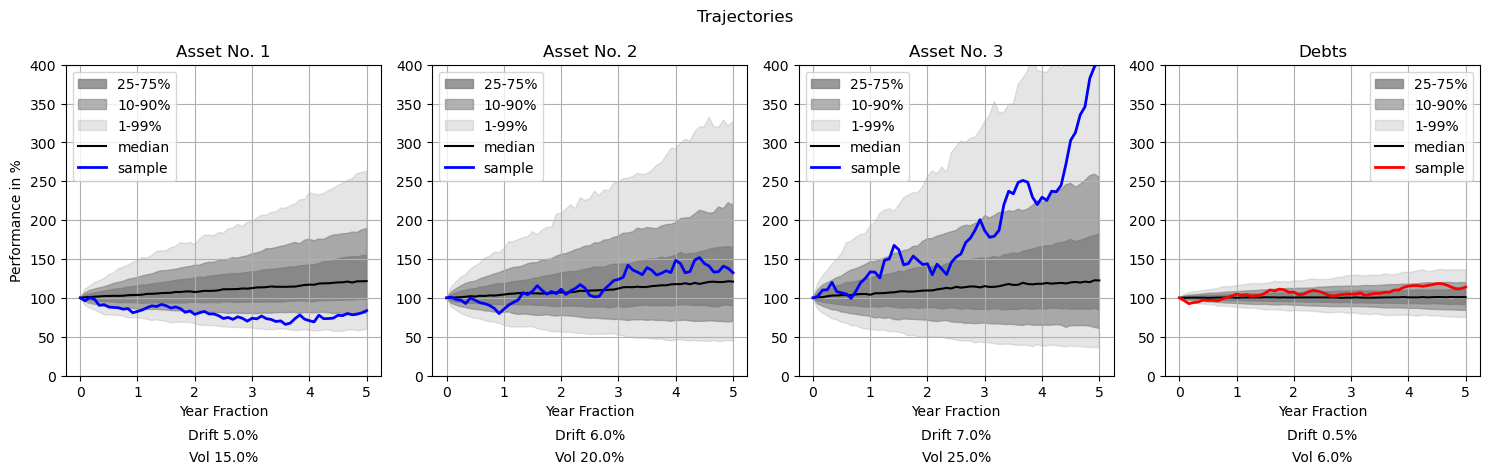

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
temp_ylim = 400

fig.suptitle("Trajectories")

k = 0
for l in range(n_investments):
    tensor = 100 * S_A[:, :, l] / S_A[0, 0, 0]
    plot50 = axes[k].plot(
        timegrid,
        np.quantile(tensor, q=0.5, axis=0),
        "k-",
    )
    q01 = np.quantile(tensor, q=0.01, axis=0)
    q10 = np.quantile(tensor, q=0.10, axis=0)
    q25 = np.quantile(tensor, q=0.25, axis=0)
    q75 = np.quantile(tensor, q=0.75, axis=0)
    q90 = np.quantile(tensor, q=0.90, axis=0)
    q99 = np.quantile(tensor, q=0.99, axis=0)
    fill50 = axes[k].fill(
        np.concatenate([timegrid, timegrid[::-1]]),
        np.concatenate([q25, q75[::-1]]),
        alpha=0.8,
        color="grey",
    )
    fill80 = axes[k].fill(
        np.concatenate([timegrid, timegrid[::-1]]),
        np.concatenate([q10, q90[::-1]]),
        alpha=0.6,
        color="grey",
    )
    fill98 = axes[k].fill(
        np.concatenate([timegrid, timegrid[::-1]]),
        np.concatenate([q01, q99[::-1]]),
        alpha=0.2,
        color="grey",
    )
    plotpath = axes[k].plot(
        timegrid,
        tensor[0, :],
        color="b",
        linewidth=2,
    )
    axes[k].set_ylim(0, temp_ylim)
    axes[k].grid()
    axes[k].set_title("Asset No. " + str(l + 1))
    axes[k].set_xlabel("Year Fraction")
    if k == 0:
        axes[k].set_ylabel("Performance in %")
    axes[k].legend(
        [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
        ["25-75%", "10-90%", "1-99%", "median", "sample"],
    )
    axes[k].text(
        2.5,
        -82,
        "Drift " + str(np.round(100 * mu_I[l].detach().numpy(), 2)) + "%",
        wrap=True,
        horizontalalignment="center",
    )
    axes[k].text(
        2.5,
        -110,
        "Vol " + str(np.round(100 * sigma_I[l].detach().numpy(), 2)) + "%",
        wrap=True,
        horizontalalignment="center",
    )
    k += 1

tensor = 100 * S_L[:, :] / L_0
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="r",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Debts")
axes[k].set_xlabel("Year Fraction")
#axes[k].set_ylabel("Performance in %")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)
axes[k].text(
    2.5,
    -82,
    "Drift " + str(np.round(100 * mu_L, 2)) + "%",
    wrap=True,
    horizontalalignment="center",
)
axes[k].text(
    2.5,
    -110,
    "Vol " + str(np.round(100 * sigma_L, 2)) + "%",
    wrap=True,
    horizontalalignment="center",
)

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_market_scenarios.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

## Benchmark «Wait & See»

### Roll-Forward

In [9]:
investments_ws = torch.zeros(n_scenarios, n_steps + 1)
cash_ws = torch.zeros(n_scenarios, n_steps + 1)
liabilities_ws = torch.zeros(n_scenarios, n_steps + 1)
equity_ws = torch.zeros(n_scenarios, n_steps + 1)
penalty_ws = torch.zeros(n_scenarios, n_steps + 1)
investments_ws[:, 0] = I_0.sum()
cash_ws[:, 0] = C_0
liabilities_ws[:, 0] = L_0
equity_ws[:, 0] = investments_ws[:, 0] + cash_ws[:, 0] - liabilities_ws[:, 0]
for t in range(n_steps):
    investments_ws[:, t + 1] = S_A_test.sum(axis=2)[:, t + 1]
    cash_ws[:, t + 1] = cash_ws[:, t]
    liabilities_ws[:, t + 1] = S_L_test[:, t + 1]
    penalty_ws[:, t + 1] = (
        torch.maximum(gamma * investments_ws[:, t] - cash_ws[:, t], torch.zeros(1))
        * kappa
    )
    penalty_ws[:, t + 1] += (
        torch.maximum(
            beta * (investments_ws[:, t] + epsilon * torch.ones(n_scenarios))
            - equity_ws[:, t],
            torch.zeros(1),
        )
        * kappa
    )
    penalty_ws[:, t + 1] += torch.maximum(-equity_ws[:, t], torch.zeros(1)) * kappa
    cash_ws[:, t + 1] = (cash_ws[:, t + 1] - penalty_ws[:, t + 1]) * np.exp(r_c * dt)
    equity_ws[:, t + 1] = (
        investments_ws[:, t + 1] + cash_ws[:, t + 1] - liabilities_ws[:, t + 1]
    )
log_returns_ws = torch.log(
    torch.maximum(equity_ws[:, -1] / equity_ws[:, 0], torch.tensor(epsilon))
)
sd_ws = torch.std(log_returns_ws)
loss_ws = (
    -log_returns_ws.mean()
    + llambda / 2 * sd_ws**2
    + torch.max(penalty_ws)  # .quantile(penalty_ws, 1 - alpha)
)
print(f"Utility {-loss_ws.item():,.6f}.")

Utility -169.532486.


### Results

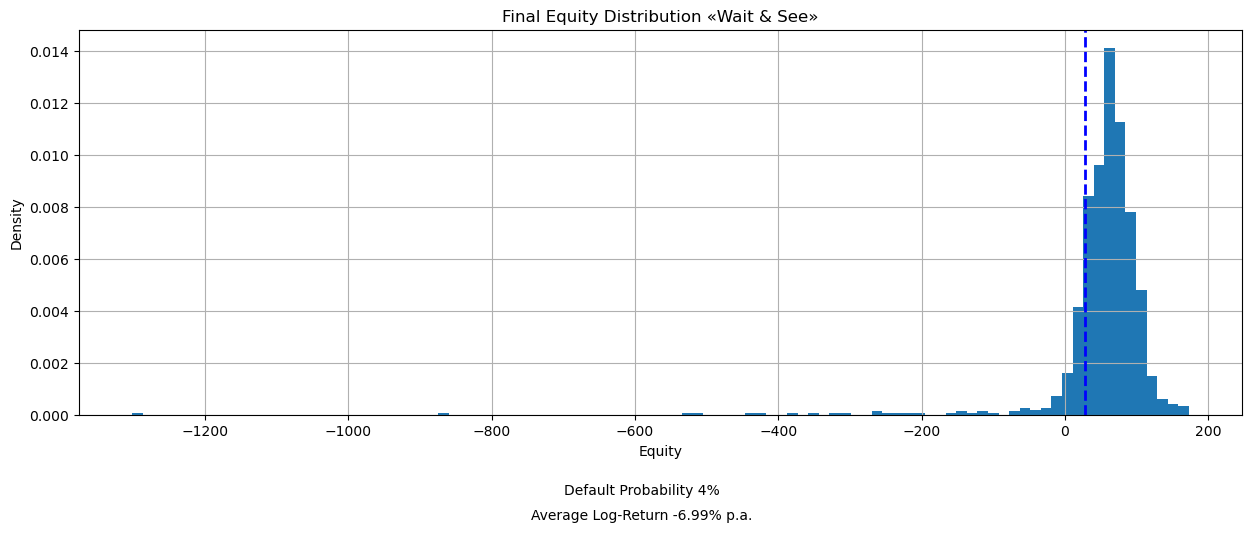

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
plt.hist(equity_ws.detach().numpy()[:, -1], bins=100, density=True)
plt.axvline(
    x=E_0 * np.exp(log_returns_ws.mean().detach().numpy()),
    color="blue",
    linestyle="--",
    linewidth=2,
)
plt.grid()
plt.title("Final Equity Distribution «Wait & See»")
plt.xlabel("Equity")
plt.ylabel("Density")
PD_ws = int(100 * np.sum(equity_ws.detach().numpy()[:, -1] < 0) / n_scenarios)
plt.figtext(
    0.5,
    -0.05,
    "Default Probability " + str(PD_ws) + "%",
    wrap=True,
    horizontalalignment="center",
)
plt.figtext(
    0.5,
    -0.10,
    "Average Log-Return "
    + str(np.round(100 * log_returns_ws.mean().detach().numpy() / T, 2))
    + "% p.a.",
    wrap=True,
    horizontalalignment="center",
)
if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_WS_Equity_Histogram.pdf", bbox_inches="tight")
plt.show()

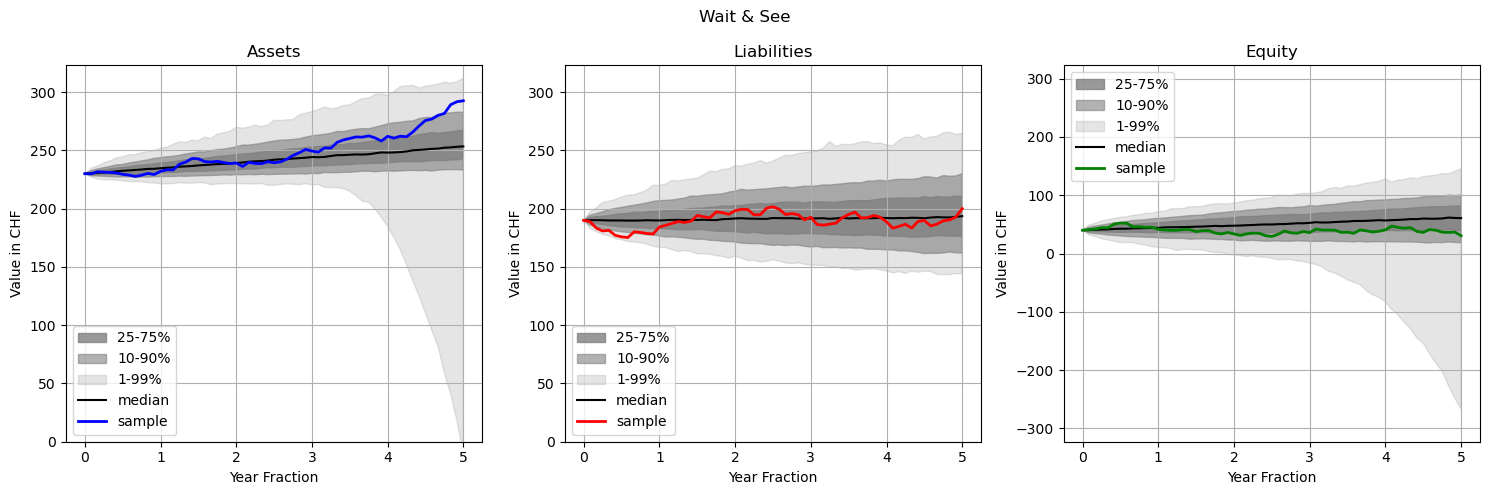

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
temp_ylim = 1.7 * L_0

fig.suptitle("Wait & See")

k = 0
tensor = S_A.sum(axis=2) + cash_ws
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Assets")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = liabilities_ws
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="r",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Liabilities")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = equity_ws
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="g",
    linewidth=2,
)
axes[k].set_ylim(-temp_ylim, temp_ylim)
axes[k].grid()
axes[k].set_title("Equity")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_WS_Risk_Profile_1.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

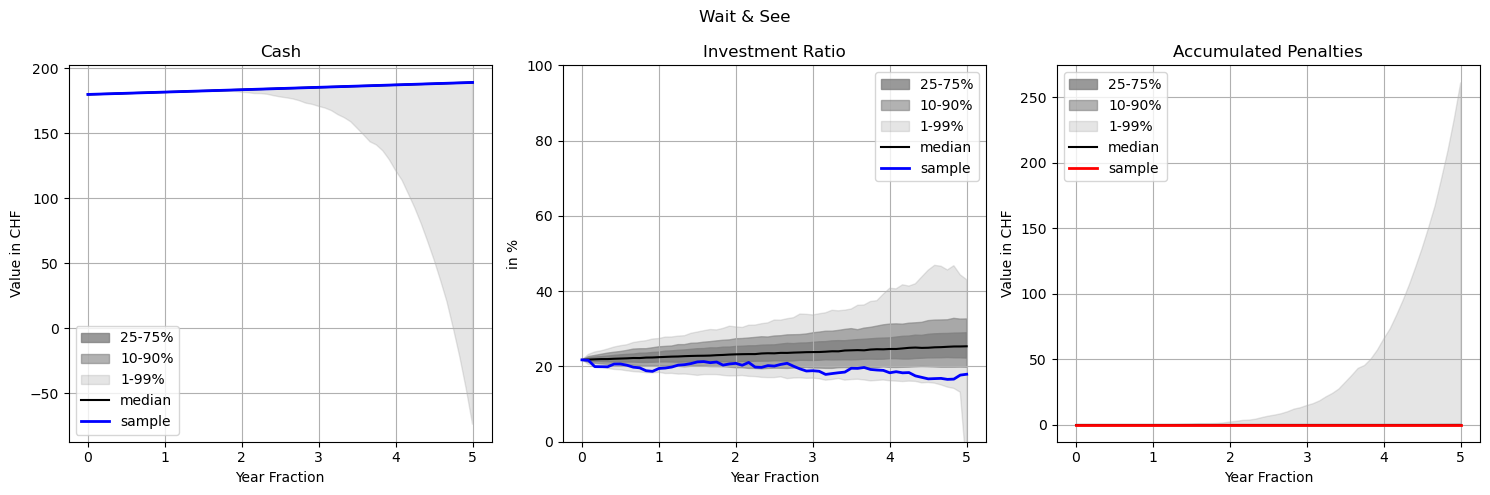

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Wait & See")
tensor = cash_ws.detach().numpy()
k = 0
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
# axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Cash")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = 100 * (
    1 - (cash_ws[:, :] / (cash_ws[:, :] + investments_ws[:, :])).detach().numpy()
)
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
axes[k].set_ylim(0, 100)
axes[k].grid()
axes[k].set_title("Investment Ratio")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("in %")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = penalty_ws.cumsum(dim=1).detach().numpy()
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="r",
    linewidth=2,
)
# axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Accumulated Penalties")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_WS_Risk_Profile_2.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

## Benchmark «No Leverage & Merton Ratio»

### Roll-Forward

In [13]:
investments_nlmr = torch.zeros(n_scenarios, n_steps + 1)
cash_nlmr = torch.zeros(n_scenarios, n_steps + 1)
liabilities_nlmr = torch.zeros(n_scenarios, n_steps + 1)
equity_nlmr = torch.zeros(n_scenarios, n_steps + 1)
penalty_nlmr = torch.zeros(n_scenarios, n_steps + 1)
investments_nlmr[:, 0] = (1 - beta) * (C_0 + I_0.sum() - L_0)
cash_nlmr[:, 0] = beta * (C_0 + I_0.sum() - L_0)
liabilities_nlmr[:, 0] = 0
equity_nlmr[:, 0] = investments_nlmr[:, 0] + cash_nlmr[:, 0]
merton_weights = mu_I / (llambda * sigma_I**2)
merton_weights_normalised = (mu_I / (llambda * sigma_I**2)) / (
    mu_I / (llambda * sigma_I**2)
).sum()
for t in range(n_steps):
    investments_pre = (
        investments_nlmr[:, t]
        * merton_weights_normalised[0]
        * S_A_test[:, t + 1, 0]
        / S_A_test[:, t, 0]
    )
    for k in range(1, n_investments):
        investments_pre += (
            investments_nlmr[:, t]
            * merton_weights_normalised[k]
            * S_A_test[:, t + 1, k]
            / S_A_test[:, t, k]
        )
    cash_pre = cash_nlmr[:, t] * np.exp(r_c * dt)
    assets_pre = cash_pre + investments_pre
    cash_nlmr[:, t + 1] = beta * assets_pre
    investments_nlmr[:, t + 1] = (1 - beta) * assets_pre
    equity_nlmr[:, t + 1] = assets_pre
log_returns_nlmr = torch.log(
    torch.maximum(equity_nlmr[:, -1] / equity_nlmr[:, 0], torch.tensor(epsilon))
)
sd_nlmr = torch.std(log_returns_nlmr)
loss_nlmr = (
    -log_returns_nlmr.mean()
    + llambda / 2 * sd_nlmr**2
    + torch.max(penalty_nlmr)  # .quantile(penalty_nlmr, 1 - alpha)
)
print(f"Utility {-loss_nlmr.item():,.6f}.")

Utility 0.195927.


### Results

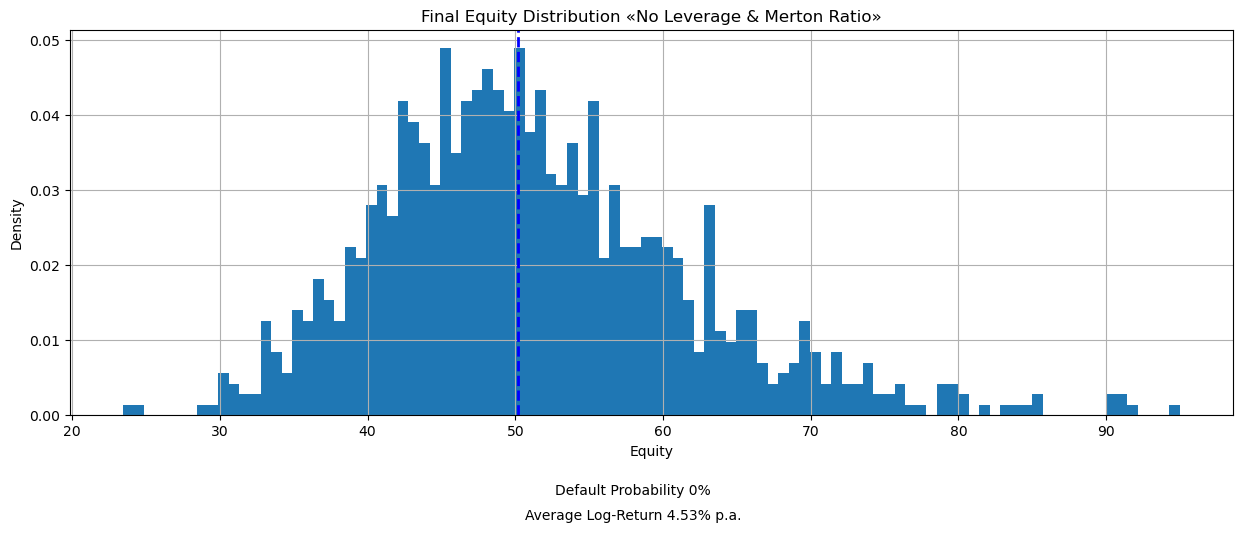

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
plt.hist(equity_nlmr.detach().numpy()[:, -1], bins=100, density=True)
plt.axvline(
    x=E_0 * np.exp(log_returns_nlmr.mean().detach().numpy()),
    color="blue",
    linestyle="--",
    linewidth=2,
)
plt.grid()
plt.title("Final Equity Distribution «No Leverage & Merton Ratio»")
plt.xlabel("Equity")
plt.ylabel("Density")
PD_nlmr = int(100 * np.sum(equity_nlmr.detach().numpy()[:, -1] < 0) / n_scenarios)
plt.figtext(
    0.5,
    -0.05,
    "Default Probability " + str(PD_nlmr) + "%",
    wrap=True,
    horizontalalignment="center",
)
plt.figtext(
    0.5,
    -0.10,
    "Average Log-Return "
    + str(np.round(100 * log_returns_nlmr.mean().detach().numpy() / T, 2))
    + "% p.a.",
    wrap=True,
    horizontalalignment="center",
)
if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_nlmr_Equity_Histogram.pdf", bbox_inches="tight")
plt.show()

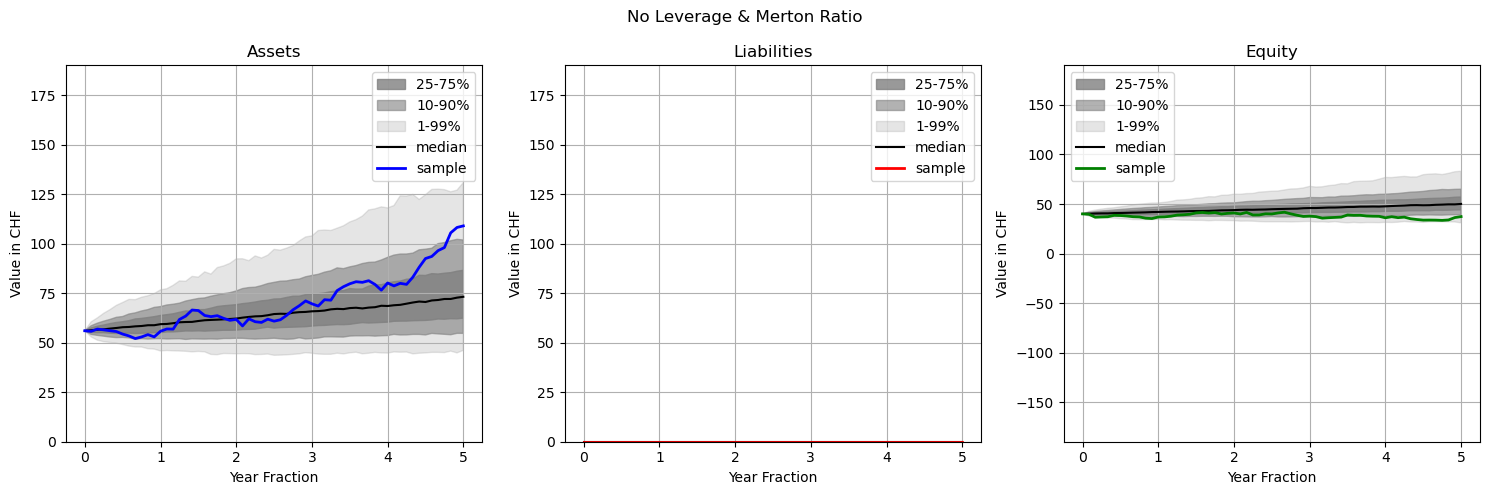

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
temp_ylim = L_0

fig.suptitle("No Leverage & Merton Ratio")

k = 0
tensor = S_A.sum(axis=2) + cash_nlmr
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Assets")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = liabilities_nlmr
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="r",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Liabilities")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = equity_nlmr
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="g",
    linewidth=2,
)
axes[k].set_ylim(-temp_ylim, temp_ylim)
axes[k].grid()
axes[k].set_title("Equity")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_nlmr_Risk_Profile_1.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

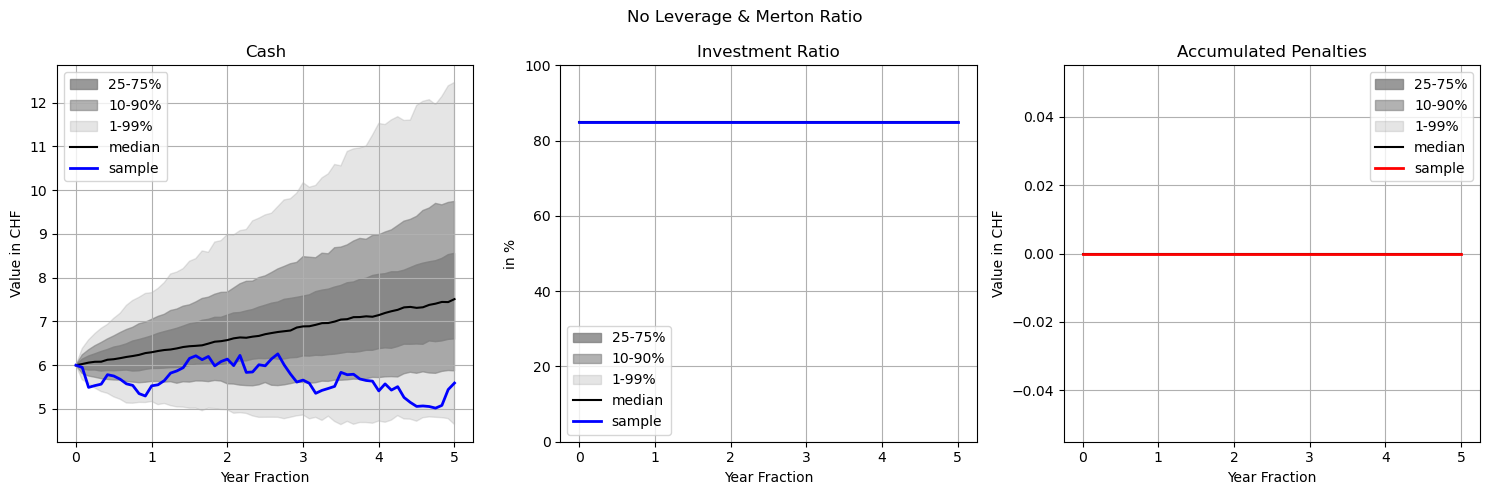

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("No Leverage & Merton Ratio")
tensor = cash_nlmr.detach().numpy()
k = 0
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
# axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Cash")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = 100 * (
    1 - (cash_nlmr[:, :] / (cash_nlmr[:, :] + investments_nlmr[:, :])).detach().numpy()
)
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
axes[k].set_ylim(0, 100)
axes[k].grid()
axes[k].set_title("Investment Ratio")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("in %")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = penalty_nlmr.cumsum(dim=1).detach().numpy()
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="r",
    linewidth=2,
)
# axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Accumulated Penalties")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_nlmr_Risk_Profile_2.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

## Static Replication I

### Control Variables

In [17]:
allocations_sr1 = torch.nn.Parameter(
    torch.rand(n_investments + 1), requires_grad=True
)
debt_sr1 = torch.nn.Parameter(torch.rand(n_steps), requires_grad=True)

### Optimiser

In [18]:
optimiser_sr1 = optim.Adam([allocations_sr1, debt_sr1], lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimiser_sr1, step_size=1000, gamma=0.85)
min_lr = 0.001
precision = 0.0001

### Feed Forward and Backpropagation

In [19]:
if DEBUGGING_MODE_STATIC_I:
    n_epochs_withheld = n_epochs
    n_epochs = 15
historical_loss_sr1 = torch.zeros(n_epochs)
historical_loss_sr1_test = torch.zeros(n_epochs)
validation_loss_observer = 0
temp_string = ""
for epoch in tqdm(
    range(n_epochs),
    desc="Progress",
    total=n_epochs,
    position=0,
    leave=True,
):
    investments_sr1 = torch.zeros(n_scenarios, n_steps + 1)
    cash_sr1 = torch.zeros(n_scenarios, n_steps + 1)
    liabilities_sr1 = torch.zeros(n_scenarios, n_steps + 1)
    equity_sr1 = torch.zeros(n_scenarios, n_steps + 1)
    penalty_sr1 = torch.zeros(n_scenarios, n_steps + 1)
    investments_sr1[:, 0] = I_0.sum()
    cash_sr1[:, 0] = C_0
    liabilities_sr1[:, 0] = L_0
    equity_sr1[:, 0] = investments_sr1[:, 0] + cash_sr1[:, 0] - liabilities_sr1[:, 0]
    investments_sr1_test = torch.zeros(n_scenarios, n_steps + 1)
    cash_sr1_test = torch.zeros(n_scenarios, n_steps + 1)
    liabilities_sr1_test = torch.zeros(n_scenarios, n_steps + 1)
    equity_sr1_test = torch.zeros(n_scenarios, n_steps + 1)
    penalty_sr1_test = torch.zeros(n_scenarios, n_steps + 1)
    investments_sr1_test[:, 0] = I_0.sum()
    cash_sr1_test[:, 0] = C_0
    liabilities_sr1_test[:, 0] = L_0
    equity_sr1_test[:, 0] = (
        investments_sr1_test[:, 0] + cash_sr1_test[:, 0] - liabilities_sr1_test[:, 0]
    )
    for t in range(n_steps):
        alloc_t = (
            (
                allocations_sr1[:-1]
                / torch.maximum(allocations_sr1[:-1].sum(), torch.tensor(epsilon))
                * allocations_sr1[-1]
            )
            .detach()
            .clone()
        )
        x_A_post_comp = alloc_t * (
            investments_sr1[:, t] + cash_sr1[:, t] + debt_sr1[t]
        ).unsqueeze(-1)
        x_A_post = x_A_post_comp.sum(dim=-1)
        c_post = cash_sr1[:, t] + investments_sr1[:, t] - x_A_post + debt_sr1[t]
        liabilities_post = torch.maximum(
            liabilities_sr1[:, t] + debt_sr1[t], torch.zeros(1)
        )
        equity_post = x_A_post + c_post - liabilities_post
        x_A_pre = x_A_post_comp * S_A[:, t + 1, :] / S_A[:, t, :]
        investments_sr1[:, t + 1] = x_A_pre.sum(axis=-1)
        penalty_sr1[:, t] = (
            torch.maximum(gamma * x_A_post - c_post, torch.zeros(1)) * kappa
            + torch.maximum(beta * (x_A_post + epsilon) - equity_post, torch.zeros(1))
            * kappa
            + torch.maximum(-equity_post, torch.zeros(1)) * kappa
        )
        cash_sr1[:, t + 1] = (c_post - penalty_sr1[:, t]) * torch.exp(
            torch.tensor(r_c * dt)
        )
        liabilities_sr1[:, t + 1] = liabilities_post * S_L[:, t + 1] / S_L[:, t]
        equity_sr1[:, t + 1] = (
            investments_sr1[:, t + 1] + cash_sr1[:, t + 1] - liabilities_sr1[:, t + 1]
        )
    log_returns_sr1 = torch.log(
        torch.maximum(equity_sr1[:, -1] / equity_sr1[:, 0], torch.tensor(epsilon))
    )
    sd_sr1 = torch.std(log_returns_sr1)
    loss_sr1 = (
        -log_returns_sr1.mean()
        + llambda / 2 * sd_sr1**2
        + torch.max(penalty_sr1)  # .quantile(penalty_sr1, 1 - alpha)
    )
    historical_loss_sr1[epoch] = loss_sr1.detach().clone()
    optimiser_sr1.zero_grad()
    loss_sr1.backward()
    optimiser_sr1.step()
    scheduler.step()
    if VALIDATION_LOSS_STATIC_I:
        for t in range(n_steps):
            alloc_t = (
                (
                    allocations_sr1[:-1]
                    / torch.maximum(allocations_sr1[:-1].sum(), torch.tensor(epsilon))
                    * allocations_sr1[-1]
                )
                .detach()
                .clone()
            )
            x_A_post_comp = alloc_t * (
                investments_sr1_test[:, t] + cash_sr1_test[:, t] + debt_sr1[t]
            ).unsqueeze(-1)
            x_A_post = x_A_post_comp.sum(dim=-1)
            c_post = (
                cash_sr1_test[:, t]
                + investments_sr1_test[:, t]
                - x_A_post
                + debt_sr1[t]
            )
            liabilities_post = torch.maximum(
                liabilities_sr1_test[:, t] + debt_sr1[t], torch.zeros(1)
            )
            equity_post = x_A_post + c_post - liabilities_post
            x_A_pre = x_A_post_comp * S_A_test[:, t + 1, :] / S_A_test[:, t, :]
            investments_sr1_test[:, t + 1] = x_A_pre.sum(axis=-1)
            penalty_sr1_test[:, t] = (
                torch.maximum(gamma * x_A_post - c_post, torch.zeros(1)) * kappa
                + torch.maximum(
                    beta * (x_A_post + epsilon) - equity_post, torch.zeros(1)
                )
                * kappa
                + torch.maximum(-equity_post, torch.zeros(1)) * kappa
            )
            cash_sr1_test[:, t + 1] = (c_post - penalty_sr1_test[:, t]) * torch.exp(
                torch.tensor(r_c * dt)
            )
            liabilities_sr1_test[:, t + 1] = (
                liabilities_post * S_L_test[:, t + 1] / S_L_test[:, t]
            )
            equity_sr1_test[:, t + 1] = (
                investments_sr1_test[:, t + 1]
                + cash_sr1_test[:, t + 1]
                - liabilities_sr1_test[:, t + 1]
            )
        log_returns_sr1_test = torch.log(
            torch.maximum(
                equity_sr1_test[:, -1] / equity_sr1_test[:, 0], torch.tensor(epsilon)
            )
        )
        sd_sr1_test = torch.std(log_returns_sr1_test)
        loss_sr1_test = (
            -log_returns_sr1_test.mean()
            + llambda / 2 * sd_sr1_test**2
            + torch.max(penalty_sr1_test)  # .quantile(penalty_sr1_test, 1 - alpha)
        )
        historical_loss_sr1_test[epoch] = loss_sr1_test.detach().clone()
        temp_string = f" (Training) / {-loss_sr1_test.item():,.6f} (Validation)        "
    if epoch % 5 == 0:
        tqdm.write(
            f"\rEpoch {epoch:,.0f}: Utility {-loss_sr1.item():,.6f}" + temp_string,
            end="",
        )
        S_A, S_L = simulate_paths()
    if (
        epoch > 500
        and torch.abs(historical_loss_sr1[epoch] - historical_loss_sr1[epoch - 500])
        < precision
    ) and not VALIDATION_LOSS_STATIC_I:
        break
    if (
        historical_loss_sr1_test[epoch] - historical_loss_sr1_test[epoch - 1] < 0
    ) and VALIDATION_LOSS_STATIC_I:
        validation_loss_observer = 0
    else:
        validation_loss_observer += 1
        if validation_loss_observer == PATIENCE:
            break
    for param_group in optimiser_sr1.param_groups:
        if param_group["lr"] < min_lr:
            param_group["lr"] = min_lr
if DEBUGGING_MODE_STATIC_I:
    n_epochs = n_epochs_withheld
tqdm.write(
    f"\rEpoch {epoch + 1:,.0f}: Utility {-loss_sr1.item():,.6f}" + temp_string, end=""
)
if not VALIDATION_LOSS_STATIC_I:
    investments_sr1_test = investments_sr1.detach().clone()
    cash_sr1_test = cash_sr1_test.detach().clone()
    liabilities_sr1_test = liabilities_sr1_test.detach().clone()
    equity_sr1_test = equity_sr1_test.detach().clone()
    penalty_sr1_test = penalty_sr1_test.detach().clone()

Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 4,106: Utility -0.009718 (Training) / 0.017724 (Validation)             

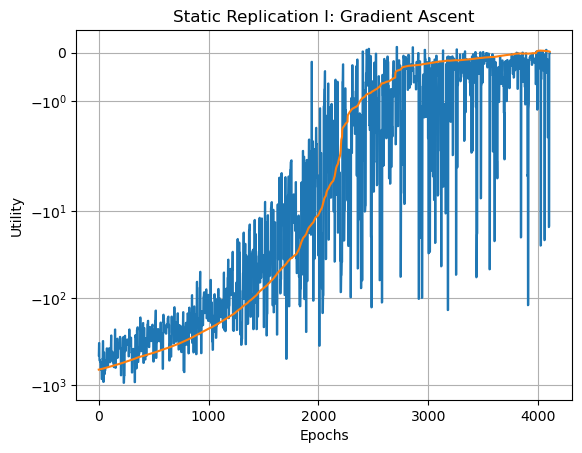

In [20]:
plt.plot(
    range(1 if epoch < n_epochs - 1 or n_epochs <= 100 else 101, epoch + 1),
    -historical_loss_sr1[0 if epoch < n_epochs - 1 or n_epochs <= 100 else 100 : epoch],
)
if VALIDATION_LOSS_STATIC_I:
    plt.plot(
        range(1 if epoch < n_epochs - 1 or n_epochs <= 100 else 101, epoch + 1),
        -historical_loss_sr1_test[0 if epoch < n_epochs - 1 or n_epochs <= 100 else 100 : epoch],
    )
plt.yscale("symlog")
plt.grid()
plt.title("Static Replication I: Gradient Ascent")
plt.xlabel("Epochs")
plt.ylabel("Utility")

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_SRI_Loss_History.pdf", bbox_inches="tight")

plt.show()

### Results

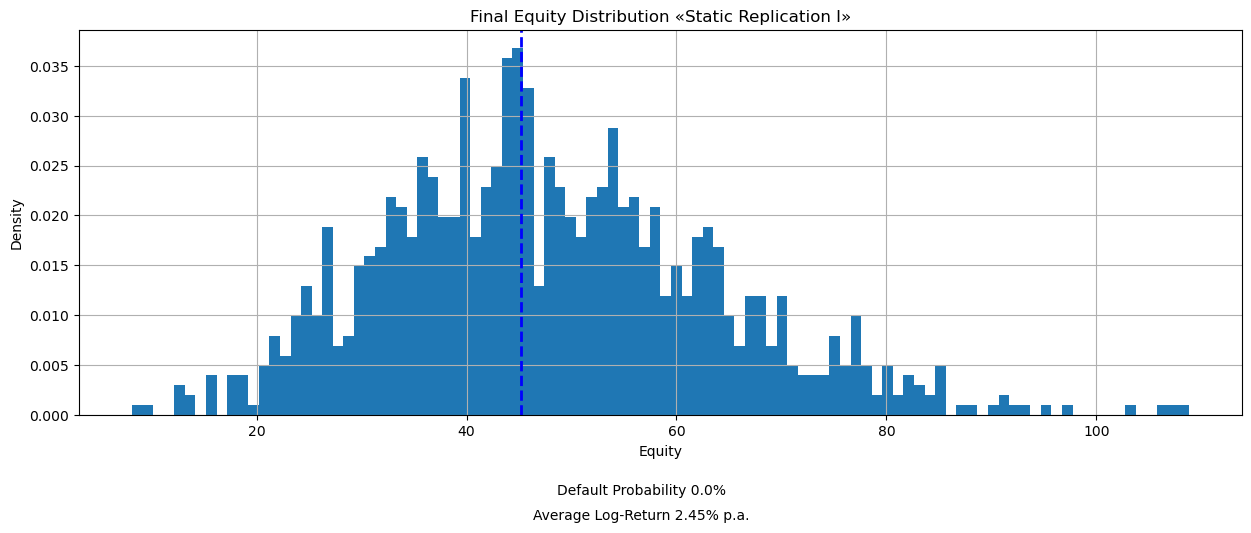

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
plt.hist(equity_sr1_test.detach().numpy()[:, -1], bins=100, density=True)
# plt.hist(equity_sr1.detach().numpy()[:, -1], bins=100, density=True, alpha=0.5)
plt.axvline(
    x=E_0 * np.exp(log_returns_sr1_test.mean().detach().numpy()),
    color="blue",
    linestyle="--",
    linewidth=2,
)
# plt.hist(equity_ws.detach().numpy()[:, -1], bins=100, density=True, alpha=0.5)
plt.grid()
plt.title("Final Equity Distribution «Static Replication I»")
plt.xlabel("Equity")
plt.ylabel("Density")
PD_sr1_test = np.round(
    100 * np.sum(equity_sr1_test.detach().numpy()[:, -1] < 0) / n_scenarios, 2
)
plt.figtext(
    0.5,
    -0.05,
    "Default Probability " + str(PD_sr1_test) + "%",
    wrap=True,
    horizontalalignment="center",
)
plt.figtext(
    0.5,
    -0.10,
    "Average Log-Return "
    + str(np.round(100 * log_returns_sr1_test.mean().detach().numpy() / T, 2))
    + "% p.a.",
    wrap=True,
    horizontalalignment="center",
)
if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_SRI_Equity_Histogram.pdf", bbox_inches="tight")
plt.show()

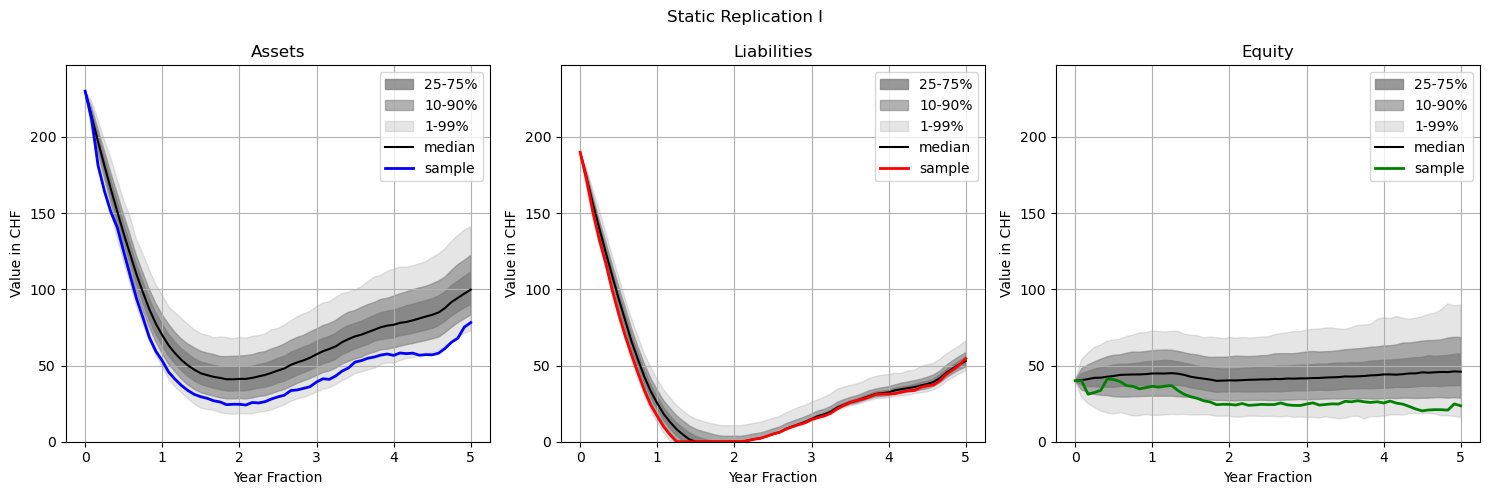

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
temp_ylim = 1.3 * L_0

fig.suptitle("Static Replication I")
tensor = (investments_sr1_test + cash_sr1_test).detach().numpy()
k = 0
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Assets")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = liabilities_sr1_test.detach().numpy()
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="r",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Liabilities")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = equity_sr1_test.detach().numpy()
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="g",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Equity")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_SRI_Risk_Profile_1.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

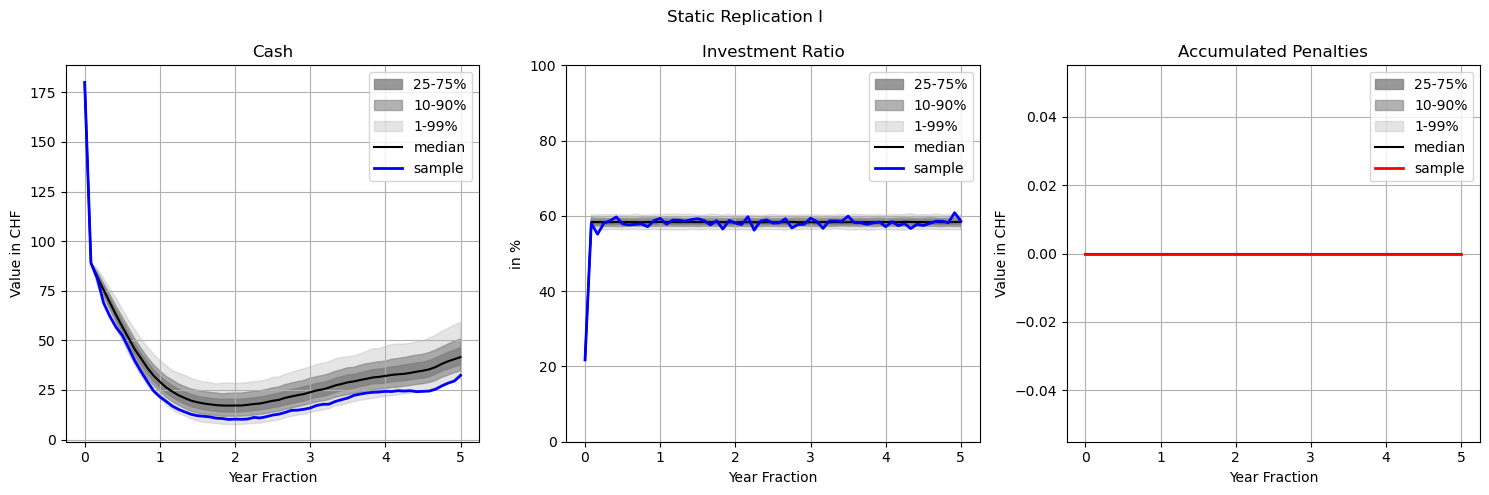

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Static Replication I")
tensor = cash_sr1_test.detach().numpy()
k = 0
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
#axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Cash")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = 100 * (1 - (cash_sr1_test[:, :] / (cash_sr1_test[:, :] + investments_sr1_test[:, :])).detach().numpy())
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
axes[k].set_ylim(0, 100)
axes[k].grid()
axes[k].set_title("Investment Ratio")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("in %")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = penalty_sr1_test.cumsum(dim=1).detach().numpy()
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="r",
    linewidth=2,
)
#axes[k].set_ylim(0, ylim_temp)
axes[k].grid()
axes[k].set_title("Accumulated Penalties")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_SRI_Risk_Profile_2.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

## Static Replication II

### Control Variables

In [24]:
allocations_sr2 = torch.nn.Parameter(
    torch.rand(n_steps, n_investments + 1), requires_grad=True
)
debt_sr2 = torch.nn.Parameter(torch.rand(n_steps), requires_grad=True)

### Optimiser

In [25]:
optimiser_sr2 = optim.Adam([allocations_sr2, debt_sr2], lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimiser_sr2, step_size=1000, gamma=0.85)
min_lr = 0.001
precision = 0.0001

### Feed Forward and Backpropagation

In [26]:
if DEBUGGING_MODE_STATIC_II:
    n_epochs_withheld = n_epochs
    n_epochs = 15
historical_loss_sr2 = torch.zeros(n_epochs)
historical_loss_sr2_test = torch.zeros(n_epochs)
validation_loss_observer = 0
temp_string = ""
for epoch in tqdm(
    range(n_epochs),
    desc="Progress",
    total=n_epochs,
    position=0,
    leave=True,
):
    investments_sr2 = torch.zeros(n_scenarios, n_steps + 1)
    cash_sr2 = torch.zeros(n_scenarios, n_steps + 1)
    liabilities_sr2 = torch.zeros(n_scenarios, n_steps + 1)
    equity_sr2 = torch.zeros(n_scenarios, n_steps + 1)
    penalty_sr2 = torch.zeros(n_scenarios, n_steps + 1)
    investments_sr2[:, 0] = I_0.sum()
    cash_sr2[:, 0] = C_0
    liabilities_sr2[:, 0] = L_0
    equity_sr2[:, 0] = investments_sr2[:, 0] + cash_sr2[:, 0] - liabilities_sr2[:, 0]
    investments_sr2_test = torch.zeros(n_scenarios, n_steps + 1)
    cash_sr2_test = torch.zeros(n_scenarios, n_steps + 1)
    liabilities_sr2_test = torch.zeros(n_scenarios, n_steps + 1)
    equity_sr2_test = torch.zeros(n_scenarios, n_steps + 1)
    penalty_sr2_test = torch.zeros(n_scenarios, n_steps + 1)
    investments_sr2_test[:, 0] = I_0.sum()
    cash_sr2_test[:, 0] = C_0
    liabilities_sr2_test[:, 0] = L_0
    equity_sr2_test[:, 0] = (
        investments_sr2_test[:, 0] + cash_sr2_test[:, 0] - liabilities_sr2_test[:, 0]
    )
    for t in range(n_steps):
        alloc_t = (
            (
                allocations_sr2[t, :-1]
                / torch.maximum(allocations_sr2[t, :-1].sum(), torch.tensor(epsilon))
                * allocations_sr2[t, -1]
            )
            .detach()
            .clone()
        )
        x_A_post_comp = alloc_t * (
            investments_sr2[:, t] + cash_sr2[:, t] + debt_sr2[t]
        ).unsqueeze(-1)
        x_A_post = x_A_post_comp.sum(dim=-1)
        c_post = cash_sr2[:, t] + investments_sr2[:, t] - x_A_post + debt_sr2[t]
        liabilities_post = torch.maximum(
            liabilities_sr2[:, t] + debt_sr2[t], torch.zeros(1)
        )
        equity_post = x_A_post + c_post - liabilities_post
        x_A_pre = x_A_post_comp * S_A[:, t + 1, :] / S_A[:, t, :]
        investments_sr2[:, t + 1] = x_A_pre.sum(axis=-1)
        penalty_sr2[:, t] = (
            torch.maximum(gamma * x_A_post - c_post, torch.zeros(1)) * kappa
            + torch.maximum(beta * (x_A_post + epsilon) - equity_post, torch.zeros(1))
            * kappa
            + torch.maximum(-equity_post, torch.zeros(1)) * kappa
        )
        cash_sr2[:, t + 1] = (c_post - penalty_sr2[:, t]) * torch.exp(
            torch.tensor(r_c * dt)
        )
        liabilities_sr2[:, t + 1] = liabilities_post * S_L[:, t + 1] / S_L[:, t]
        equity_sr2[:, t + 1] = (
            investments_sr2[:, t + 1] + cash_sr2[:, t + 1] - liabilities_sr2[:, t + 1]
        )
    log_returns_sr2 = torch.log(
        torch.maximum(equity_sr2[:, -1] / equity_sr2[:, 0], torch.tensor(epsilon))
    )
    sd_sr2 = torch.std(log_returns_sr2)
    loss_sr2 = (
        -log_returns_sr2.mean()
        + llambda / 2 * sd_sr2**2
        + torch.max(penalty_sr2)  # .quantile(penalty_sr2, 1 - alpha)
    )
    historical_loss_sr2[epoch] = loss_sr2.detach().clone()
    optimiser_sr2.zero_grad()
    loss_sr2.backward()
    optimiser_sr2.step()
    scheduler.step()
    if VALIDATION_LOSS_STATIC_II:
        for t in range(n_steps):
            alloc_t = (
                (
                    allocations_sr2[t, :-1]
                    / torch.maximum(
                        allocations_sr2[t, :-1].sum(), torch.tensor(epsilon)
                    )
                    * allocations_sr2[t, -1]
                )
                .detach()
                .clone()
            )
            x_A_post_comp = alloc_t * (
                investments_sr2_test[:, t] + cash_sr2_test[:, t] + debt_sr2[t]
            ).unsqueeze(-1)
            x_A_post = x_A_post_comp.sum(dim=-1)
            c_post = (
                cash_sr2_test[:, t]
                + investments_sr2_test[:, t]
                - x_A_post
                + debt_sr2[t]
            )
            liabilities_post = torch.maximum(
                liabilities_sr2_test[:, t] + debt_sr2[t], torch.zeros(1)
            )
            equity_post = x_A_post + c_post - liabilities_post
            x_A_pre = x_A_post_comp * S_A_test[:, t + 1, :] / S_A_test[:, t, :]
            investments_sr2_test[:, t + 1] = x_A_pre.sum(axis=-1)
            penalty_sr2_test[:, t] = (
                torch.maximum(gamma * x_A_post - c_post, torch.zeros(1)) * kappa
                + torch.maximum(
                    beta * (x_A_post + epsilon) - equity_post, torch.zeros(1)
                )
                * kappa
                + torch.maximum(-equity_post, torch.zeros(1)) * kappa
            )
            cash_sr2_test[:, t + 1] = (c_post - penalty_sr2_test[:, t]) * torch.exp(
                torch.tensor(r_c * dt)
            )
            liabilities_sr2_test[:, t + 1] = (
                liabilities_post * S_L_test[:, t + 1] / S_L_test[:, t]
            )
            equity_sr2_test[:, t + 1] = (
                investments_sr2_test[:, t + 1]
                + cash_sr2_test[:, t + 1]
                - liabilities_sr2_test[:, t + 1]
            )
        log_returns_sr2_test = torch.log(
            torch.maximum(
                equity_sr2_test[:, -1] / equity_sr2_test[:, 0], torch.tensor(epsilon)
            )
        )
        sd_sr2_test = torch.std(log_returns_sr2_test)
        loss_sr2_test = (
            -log_returns_sr2_test.mean()
            + llambda / 2 * sd_sr2_test**2
            + torch.max(penalty_sr2_test)  # .quantile(penalty_sr2_test, 1 - alpha)
        )
        historical_loss_sr2_test[epoch] = loss_sr2_test.detach().clone()
        temp_string = f" (Training) / {-loss_sr2_test.item():,.6f} (Validation)        "
    if epoch % 5 == 0:
        tqdm.write(
            f"\rEpoch {epoch:,.0f}: Utility {-loss_sr2.item():,.6f}" + temp_string,
            end="",
        )
        S_A, S_L = simulate_paths()
    if (
        epoch > 500
        and torch.abs(historical_loss_sr2[epoch] - historical_loss_sr2[epoch - 500])
        < precision
    ) and not VALIDATION_LOSS_STATIC_II:
        break
    if (
        historical_loss_sr2_test[epoch] - historical_loss_sr2_test[epoch - 1] < 0
    ) and VALIDATION_LOSS_STATIC_II:
        validation_loss_observer = 0
    else:
        validation_loss_observer += 1
        if validation_loss_observer == PATIENCE:
            break
    for param_group in optimiser_sr2.param_groups:
        if param_group["lr"] < min_lr:
            param_group["lr"] = min_lr
if DEBUGGING_MODE_STATIC_II:
    n_epochs = n_epochs_withheld
tqdm.write(
    f"\rEpoch {epoch + 1:,.0f}: Utility {-loss_sr2.item():,.6f}" + temp_string, end=""
)
if not VALIDATION_LOSS_STATIC_II:
    investments_sr2_test = investments_sr2.detach().clone()
    cash_sr2_test = cash_sr2_test.detach().clone()
    liabilities_sr2_test = liabilities_sr2_test.detach().clone()
    equity_sr2_test = equity_sr2_test.detach().clone()
    penalty_sr2_test = penalty_sr2_test.detach().clone()

Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 5,000: Utility -1.165234 (Training) / -1.622598 (Validation)            

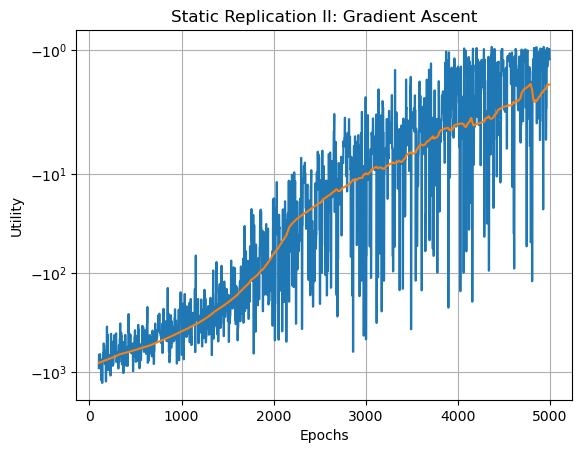

In [27]:
plt.plot(
    range(1 if epoch < n_epochs - 1 or n_epochs <= 100 else 101, epoch + 1),
    -historical_loss_sr2[0 if epoch < n_epochs - 1 or n_epochs <= 100 else 100 : epoch],
)
if VALIDATION_LOSS_STATIC_II:
    plt.plot(
        range(1 if epoch < n_epochs - 1 or n_epochs <= 100 else 101, epoch + 1),
        -historical_loss_sr2_test[
            0 if epoch < n_epochs - 1 or n_epochs <= 100 else 100 : epoch
        ],
    )
plt.yscale("symlog")
plt.grid()
plt.title("Static Replication II: Gradient Ascent")
plt.xlabel("Epochs")
plt.ylabel("Utility")

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_SRII_Loss_History.pdf", bbox_inches="tight")

plt.show()

### Results

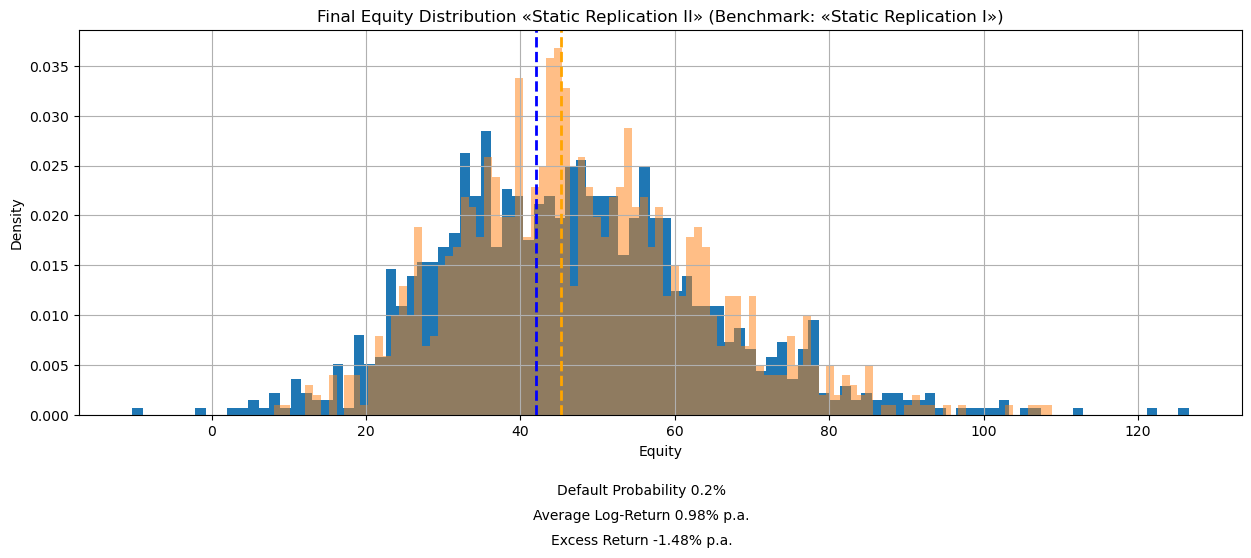

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
plt.hist(equity_sr2_test.detach().numpy()[:, -1], bins=100, density=True)
plt.axvline(
    x=E_0 * np.exp(log_returns_sr2_test.mean().detach().numpy()),
    color="blue",
    linestyle="--",
    linewidth=2,
)
plt.hist(equity_sr1_test.detach().numpy()[:, -1], bins=100, density=True, alpha=0.5)
plt.axvline(
    x=E_0 * np.exp(log_returns_sr1_test.mean().detach().numpy()),
    color="orange",
    linestyle="--",
    linewidth=2,
)
# plt.hist(equity_sr2.detach().numpy()[:, -1], bins=100, density=True, alpha=0.5)
# plt.hist(equity_ws.detach().numpy()[:, -1], bins=100, density=True, alpha=0.5)
plt.grid()
plt.title(
    "Final Equity Distribution «Static Replication II» (Benchmark: «Static Replication I»)"
)
plt.xlabel("Equity")
plt.ylabel("Density")
PD_sr2_test = np.round(
    100 * np.sum(equity_sr2_test.detach().numpy()[:, -1] < 0) / n_scenarios, 2
)
ERsr2_test_vs_sr1 = np.round(
    100
    * (
        log_returns_sr2_test.mean().detach().numpy()
        - log_returns_sr1_test.mean().detach().numpy()
    )
    / T,
    2,
)
plt.figtext(
    0.5,
    -0.05,
    "Default Probability " + str(PD_sr2_test) + "%",
    wrap=True,
    horizontalalignment="center",
)
plt.figtext(
    0.5,
    -0.10,
    "Average Log-Return "
    + str(np.round(100 * log_returns_sr2_test.mean().detach().numpy() / T, 2))
    + "% p.a.",
    wrap=True,
    horizontalalignment="center",
)
plt.figtext(
    0.5,
    -0.15,
    "Excess Return " + str(ERsr2_test_vs_sr1) + "% p.a.",
    wrap=True,
    horizontalalignment="center",
)
if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_SRII_Equity_Histogram.pdf", bbox_inches="tight")
plt.show()

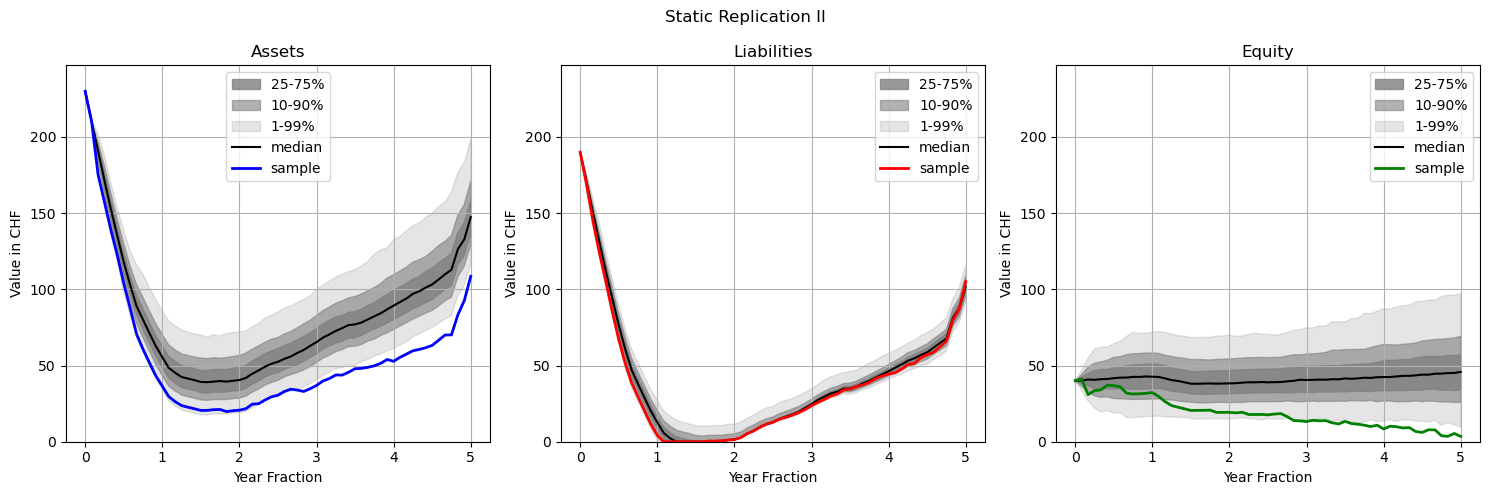

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
temp_ylim = 1.3 * L_0

fig.suptitle("Static Replication II")
tensor = (investments_sr2_test + cash_sr2_test).detach().numpy()
k = 0
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Assets")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = liabilities_sr2_test.detach().numpy()
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="r",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Liabilities")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = equity_sr2_test.detach().numpy()
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="g",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Equity")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_SRII_Risk_Profile_1.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

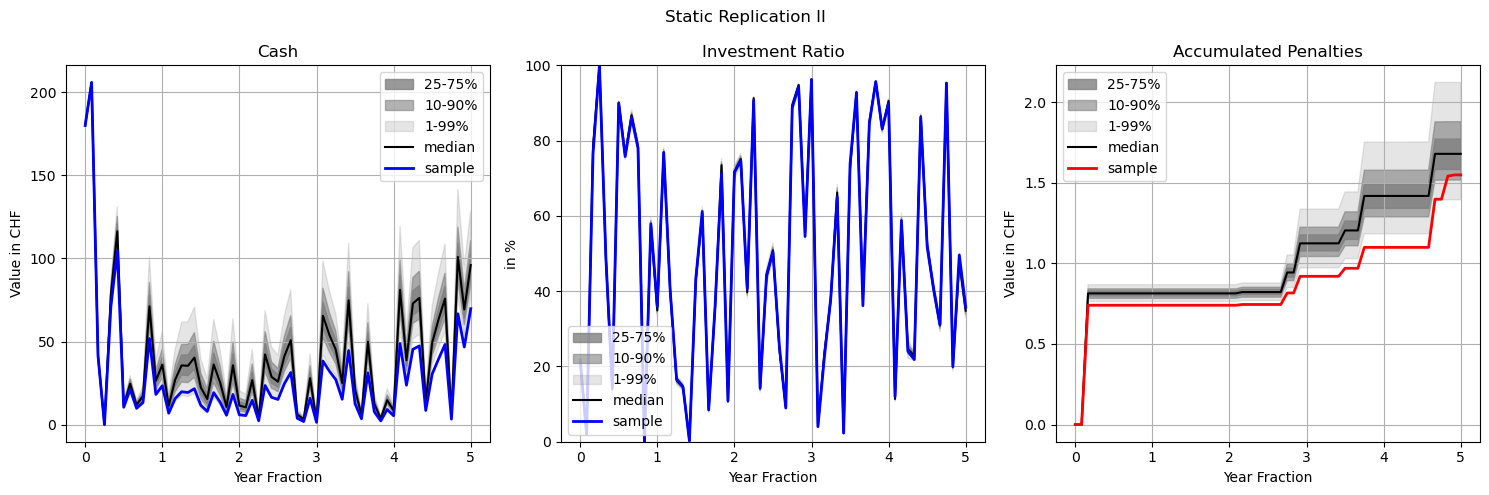

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Static Replication II")
tensor = cash_sr2_test.detach().numpy()
k = 0
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
#axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Cash")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = 100 * (1 - (cash_sr2_test[:, :] / (cash_sr2_test[:, :] + investments_sr2_test[:, :])).detach().numpy())
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
axes[k].set_ylim(0, 100)
axes[k].grid()
axes[k].set_title("Investment Ratio")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("in %")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = penalty_sr2_test.cumsum(dim=1).detach().numpy()
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="r",
    linewidth=2,
)
#axes[k].set_ylim(0, ylim_temp)
axes[k].grid()
axes[k].set_title("Accumulated Penalties")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_SRII_Risk_Profile_2.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

## Dynamic Replication

### Configuration

In [31]:
nn_layer_sizes = [4 + n_investments - 1, 10, 10, n_investments + 2]
nn_hidden_activation = nn.ReLU()
nn_output_activation = nn.Sigmoid()

### Neural Network (Control Variables)

In [32]:
class NN_Restructuring(nn.Module):
    def __init__(self, layer_sizes):
        super(NN_Restructuring, self).__init__()
        self.layers = nn.ModuleList()
        for k in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[k], layer_sizes[k + 1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = nn_hidden_activation(layer(x))
        x = nn_output_activation(self.layers[-1](x))
        return x


deep_alm = NN_Restructuring(nn_layer_sizes)

### Optimiser

In [33]:
optimiser_dr = optim.Adam(deep_alm.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimiser_dr, step_size=1000, gamma=0.85)
min_lr = 0.0001
precision = 0.0001

### Feed Forward and Backpropagation

In [34]:
if DEBUGGING_MODE_DYNAMIC:
    n_epochs_withheld = n_epochs
    n_epochs = 15
    torch.autograd.set_detect_anomaly(True)
historical_loss_dr = torch.zeros(n_epochs)
historical_loss_dr_test = torch.zeros(n_epochs)
validation_loss_observer = 0
temp_string = ""
for epoch in tqdm(
    range(n_epochs),
    desc="Progress",
    total=n_epochs,
    position=0,
    leave=True,
):
    investments_dr = torch.zeros(n_scenarios, n_steps + 1)
    cash_dr = torch.zeros(n_scenarios, n_steps + 1)
    liabilities_dr = torch.zeros(n_scenarios, n_steps + 1)
    equity_dr = torch.zeros(n_scenarios, n_steps + 1)
    penalty_dr = torch.zeros(n_scenarios, n_steps + 1)
    investments_dr[:, 0] = I_0.sum()
    cash_dr[:, 0] = C_0
    liabilities_dr[:, 0] = L_0
    equity_dr[:, 0] = investments_dr[:, 0] + cash_dr[:, 0] - liabilities_dr[:, 0]
    investments_dr_test = torch.zeros(n_scenarios, n_steps + 1)
    cash_dr_test = torch.zeros(n_scenarios, n_steps + 1)
    liabilities_dr_test = torch.zeros(n_scenarios, n_steps + 1)
    equity_dr_test = torch.zeros(n_scenarios, n_steps + 1)
    penalty_dr_test = torch.zeros(n_scenarios, n_steps + 1)
    investments_dr_test[:, 0] = I_0.sum()
    cash_dr_test[:, 0] = C_0
    liabilities_dr_test[:, 0] = L_0
    equity_dr_test[:, 0] = (
        investments_dr_test[:, 0] + cash_dr_test[:, 0] - liabilities_dr_test[:, 0]
    )
    for t in range(n_steps):
        nn_input = [
            (investments_dr[:, t] + cash_dr[:, t]) / (I_0.sum() + C_0),
            cash_dr[:, t].clone()
            / torch.maximum(
                (investments_dr[:, t] + cash_dr[:, t]).clone(), torch.tensor(epsilon)
            ),
            S_L[:, t] / L_0,
            equity_dr[:, t].clone()
            / torch.maximum(
                (investments_dr[:, t] + cash_dr[:, t]).clone(), torch.tensor(epsilon)
            ),
        ]
        nn_input.extend(
            [S_A[:, t, k] / S_A.sum(axis=2)[:, t] for k in range(n_investments - 1)]
        )
        nn_input = torch.stack(nn_input, dim=1)
        instructions = deep_alm(nn_input)
        debt_delta = (2 * instructions[:, -1] - torch.tensor(1)) * liabilities_dr[
            :, t
        ].detach().clone()
        alloc_t = (
            (
                instructions[:, :-2]
                / torch.maximum(
                    instructions[:, :-2].sum(dim=1, keepdim=True), torch.tensor(epsilon)
                )
                * instructions[:, -2].unsqueeze(-1)
            )
            .detach()
            .clone()
        )
        x_A_post_comp = alloc_t * (
            investments_dr[:, t] + cash_dr[:, t] + debt_delta
        ).unsqueeze(-1)
        x_A_post = x_A_post_comp.sum(dim=-1)
        c_post = cash_dr[:, t] + investments_dr[:, t] - x_A_post + debt_delta
        liabilities_post = liabilities_dr[:, t] + debt_delta
        equity_post = x_A_post + c_post - liabilities_post
        x_A_pre = x_A_post_comp * S_A[:, t + 1, :] / S_A[:, t, :]
        investments_dr[:, t + 1] = x_A_pre.sum(axis=-1)
        penalty_dr[:, t] = (
            torch.maximum(gamma * x_A_post - c_post, torch.zeros(1)) * kappa
            + torch.maximum(beta * (x_A_post + epsilon) - equity_post, torch.zeros(1))
            * kappa
            + torch.maximum(-equity_post, torch.zeros(1)) * kappa
        )
        cash_dr[:, t + 1] = (c_post - penalty_dr[:, t]) * torch.exp(
            torch.tensor(r_c * dt)
        )
        liabilities_dr[:, t + 1] = liabilities_post * S_L[:, t + 1] / S_L[:, t]
        equity_dr[:, t + 1] = (
            investments_dr[:, t + 1] + cash_dr[:, t + 1] - liabilities_dr[:, t + 1]
        )
    log_returns_dr = torch.log(
        torch.maximum(equity_dr[:, -1] / equity_dr[:, 0], torch.tensor(epsilon))
    )
    sd_dr = torch.std(log_returns_dr)
    loss_dr = (
        -log_returns_dr.mean()
        + llambda / 2 * sd_dr**2
        + torch.max(penalty_dr)  # .quantile(penalty_dr, 1 - alpha)
    )
    historical_loss_dr[epoch] = loss_dr.detach().clone()
    optimiser_dr.zero_grad()
    loss_dr.backward()
    # torch.nn.utils.clip_grad_norm_(deep_alm.parameters(), max_norm=1.0)
    optimiser_dr.step()
    scheduler.step()
    if VALIDATION_LOSS_DYNAMIC:
        deep_alm.eval()
        for t in range(n_steps):
            nn_input = [
                (investments_dr_test[:, t] + cash_dr_test[:, t]) / (I_0.sum() + C_0),
                cash_dr_test[:, t].clone()
                / torch.maximum(
                    (investments_dr_test[:, t] + cash_dr_test[:, t]).clone(),
                    torch.tensor(epsilon),
                ),
                S_L_test[:, t] / L_0,
                equity_dr_test[:, t].clone()
                / torch.maximum(
                    (investments_dr_test[:, t] + cash_dr_test[:, t]).clone(),
                    torch.tensor(epsilon),
                ),
            ]
            nn_input.extend(
                [
                    S_A_test[:, t, k] / S_A_test.sum(axis=2)[:, t]
                    for k in range(n_investments - 1)
                ]
            )
            nn_input = torch.stack(nn_input, dim=1)
            instructions = deep_alm(nn_input)
            debt_delta = (
                2 * instructions[:, -1] - torch.tensor(1)
            ) * liabilities_dr_test[:, t].detach().clone()
            alloc_t = (
                (
                    instructions[:, :-2]
                    / torch.maximum(
                        instructions[:, :-2].sum(dim=1, keepdim=True),
                        torch.tensor(epsilon),
                    )
                    * instructions[:, -2].unsqueeze(-1)
                )
                .detach()
                .clone()
            )
            x_A_post_comp = alloc_t * (
                investments_dr_test[:, t] + cash_dr_test[:, t] + debt_delta
            ).unsqueeze(-1)
            x_A_post = x_A_post_comp.sum(dim=-1)
            c_post = (
                cash_dr_test[:, t] + investments_dr_test[:, t] - x_A_post + debt_delta
            )
            liabilities_post = liabilities_dr_test[:, t] + debt_delta
            equity_post = x_A_post + c_post - liabilities_post
            x_A_pre = x_A_post_comp * S_A_test[:, t + 1, :] / S_A_test[:, t, :]
            investments_dr_test[:, t + 1] = x_A_pre.sum(axis=-1)
            penalty_dr_test[:, t] = (
                torch.maximum(gamma * x_A_post - c_post, torch.zeros(1)) * kappa
                + torch.maximum(
                    beta * (x_A_post + epsilon) - equity_post, torch.zeros(1)
                )
                * kappa
                + torch.maximum(-equity_post, torch.zeros(1)) * kappa
            )
            cash_dr_test[:, t + 1] = (c_post - penalty_dr_test[:, t]) * torch.exp(
                torch.tensor(r_c * dt)
            )
            liabilities_dr_test[:, t + 1] = (
                liabilities_post * S_L_test[:, t + 1] / S_L_test[:, t]
            )
            equity_dr_test[:, t + 1] = (
                investments_dr_test[:, t + 1]
                + cash_dr_test[:, t + 1]
                - liabilities_dr_test[:, t + 1]
            )
        log_returns_dr_test = torch.log(
            torch.maximum(
                equity_dr_test[:, -1] / equity_dr_test[:, 0], torch.tensor(epsilon)
            )
        )
        sd_dr_test = torch.std(log_returns_dr_test)
        loss_dr_test = (
            -log_returns_dr_test.mean()
            + llambda / 2 * sd_dr_test**2
            + torch.max(penalty_dr_test)  # .quantile(penalty_dr_test, 1 - alpha)
        )
        deep_alm.train()
        None
        historical_loss_dr_test[epoch] = loss_dr_test.detach().clone()
        temp_string = f" (Training) / {-loss_dr_test.item():,.6f} (Validation)        "
    if (
        epoch > 500
        and torch.abs(historical_loss_dr[epoch] - historical_loss_dr[epoch - 500])
        < precision
    ):
        break
    for param_group in optimiser_dr.param_groups:
        if param_group["lr"] < min_lr:
            param_group["lr"] = min_lr
    if epoch % 5 == 0:
        tqdm.write(
            f"\rEpoch {epoch:,.0f}: Utility {-loss_dr.item():,.6f}" + temp_string,
            end="",
        )
        S_A, S_L = simulate_paths()
    if (
        epoch > 500
        and torch.abs(historical_loss_dr[epoch] - historical_loss_dr[epoch - 500])
        < precision
    ) and not VALIDATION_LOSS_DYNAMIC:
        break
    if (
        historical_loss_dr_test[epoch] - historical_loss_dr_test[epoch - 1] < 0
    ) and VALIDATION_LOSS_DYNAMIC:
        validation_loss_observer = 0
    else:
        validation_loss_observer += 1
        if validation_loss_observer == PATIENCE:
            break
if DEBUGGING_MODE_DYNAMIC:
    n_epochs = n_epochs_withheld
    torch.autograd.set_detect_anomaly(False)
tqdm.write(
    f"\rEpoch {epoch + 1:,.0f}: Utility {-loss_dr.item():,.6f}" + temp_string, end=""
)

Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 166: Utility 0.152538 (Training) / 0.155860 (Validation)        

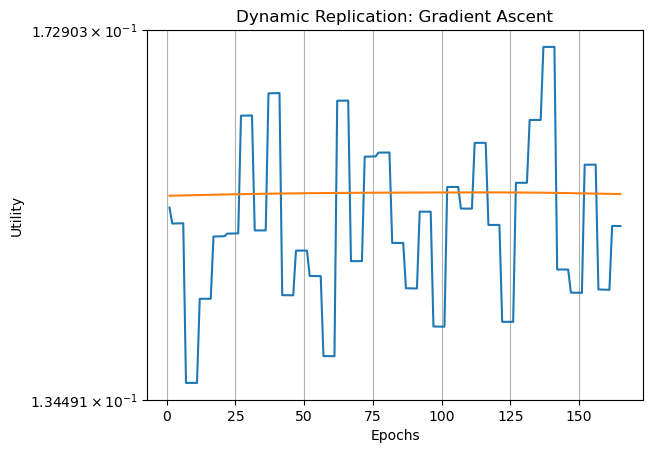

In [35]:
plt.plot(
    range(1 if epoch < n_epochs - 1 or n_epochs <= 100 else 101, epoch + 1),
    -historical_loss_dr[0 if epoch < n_epochs - 1 or n_epochs <= 100 else 100 : epoch],
)
if VALIDATION_LOSS_STATIC_I:
    plt.plot(
        range(1 if epoch < n_epochs - 1 or n_epochs <= 100 else 101, epoch + 1),
        -historical_loss_dr_test[0 if epoch < n_epochs - 1 or n_epochs <= 100 else 100 : epoch],
    )
plt.yscale("symlog")
plt.grid()
plt.title("Dynamic Replication: Gradient Ascent")
plt.xlabel("Epochs")
plt.ylabel("Utility")

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_DR_Loss_History.pdf", bbox_inches="tight")

plt.show()

### Results

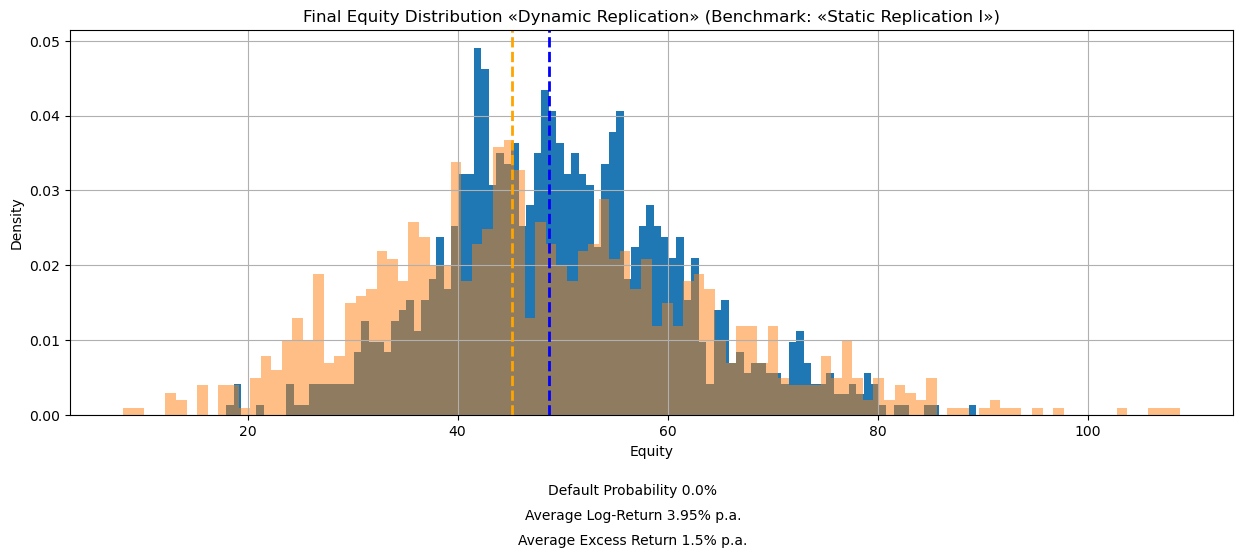

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
plt.hist(equity_dr_test.detach().numpy()[:, -1], bins=100, density=True)
plt.axvline(
    x=E_0 * np.exp(log_returns_dr_test.mean().detach().numpy()),
    color="blue",
    linestyle="--",
    linewidth=2,
)
plt.hist(equity_sr1_test.detach().numpy()[:, -1], bins=100, density=True, alpha=0.5)
plt.axvline(
    x=E_0 * np.exp(log_returns_sr1_test.mean().detach().numpy()),
    color="orange",
    linestyle="--",
    linewidth=2,
)
# plt.hist(equity_ws.detach().numpy()[:, -1], bins=100, density=True, alpha=0.5)
plt.grid()
plt.title(
    "Final Equity Distribution «Dynamic Replication» (Benchmark: «Static Replication I»)"
)
plt.xlabel("Equity")
plt.ylabel("Density")
PD_dr_test = np.round(
    100 * np.sum(equity_dr_test.detach().numpy()[:, -1] < 0) / n_scenarios, 2
)
ER_dr_vs_sr1_test = np.round(
    100
    * (
        log_returns_dr_test.mean().detach().numpy()
        - log_returns_sr1_test.mean().detach().numpy()
    )
    / T,
    2,
)
plt.figtext(
    0.5,
    -0.05,
    "Default Probability " + str(PD_dr_test) + "%",
    wrap=True,
    horizontalalignment="center",
)
plt.figtext(
    0.5,
    -0.10,
    "Average Log-Return "
    + str(np.round(100 * log_returns_dr_test.mean().detach().numpy() / T, 2))
    + "% p.a.",
    wrap=True,
    horizontalalignment="center",
)
plt.figtext(
    0.5,
    -0.15,
    "Average Excess Return " + str(ER_dr_vs_sr1_test) + "% p.a.",
    wrap=True,
    horizontalalignment="center",
)
if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_DR_Equity_Histogram.pdf", bbox_inches="tight")
plt.show()

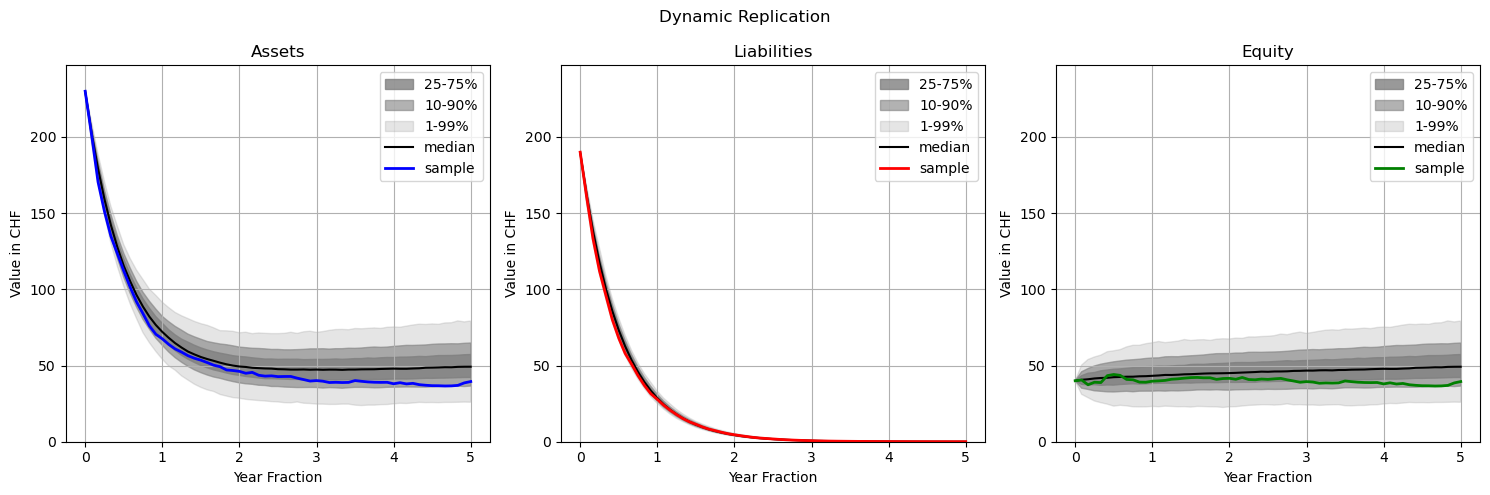

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
temp_ylim = 1.3 * L_0

fig.suptitle("Dynamic Replication")
tensor = (investments_dr_test + cash_dr_test).detach().numpy()
k = 0
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Assets")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = liabilities_dr_test.detach().numpy()
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="r",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Liabilities")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = equity_dr_test.detach().numpy()
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="g",
    linewidth=2,
)
axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Equity")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_DR_Risk_Profile_1.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

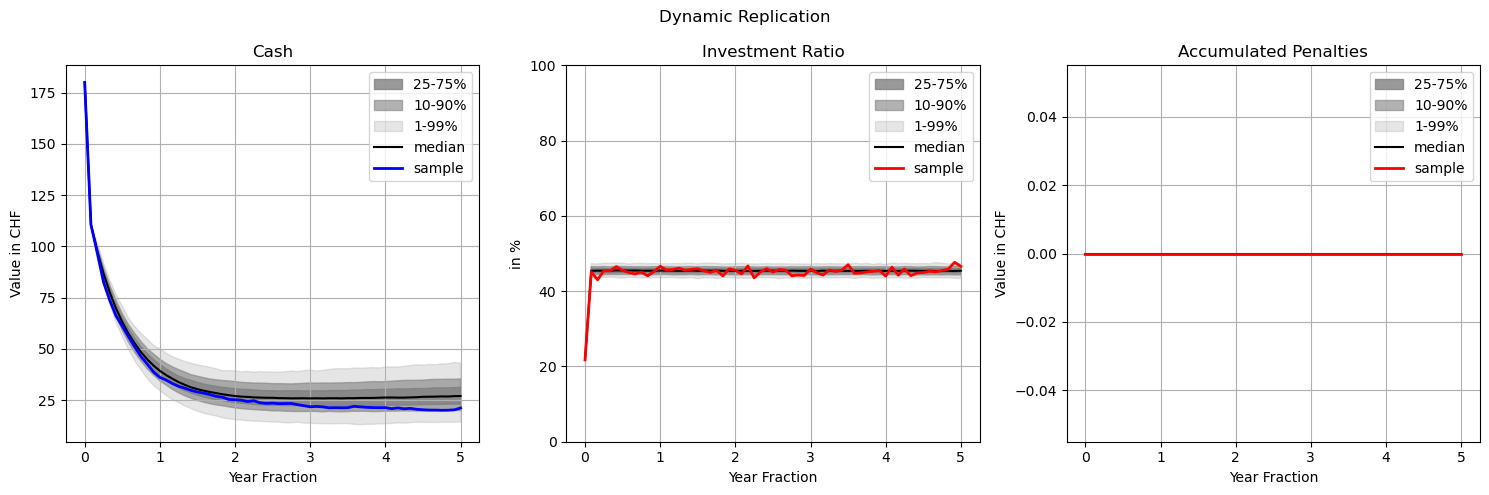

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Dynamic Replication")
tensor = cash_dr_test.detach().numpy()
k = 0
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="b",
    linewidth=2,
)
# axes[k].set_ylim(0, temp_ylim)
axes[k].grid()
axes[k].set_title("Cash")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = 100 * (
    1
    - (cash_dr_test[:, :] / (cash_dr_test[:, :] + investments_dr_test[:, :]))
    .detach()
    .numpy()
)
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="r",
    linewidth=2,
)
axes[k].set_ylim(0, 100)
axes[k].grid()
axes[k].set_title("Investment Ratio")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("in %")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

k += 1
tensor = penalty_dr_test.cumsum(dim=1).detach().numpy()
plot50 = axes[k].plot(
    timegrid,
    np.quantile(tensor, q=0.5, axis=0),
    "k-",
)
q01 = np.quantile(tensor, q=0.01, axis=0)
q10 = np.quantile(tensor, q=0.10, axis=0)
q25 = np.quantile(tensor, q=0.25, axis=0)
q75 = np.quantile(tensor, q=0.75, axis=0)
q90 = np.quantile(tensor, q=0.90, axis=0)
q99 = np.quantile(tensor, q=0.99, axis=0)
fill50 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q25, q75[::-1]]),
    alpha=0.8,
    color="grey",
)
fill80 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q10, q90[::-1]]),
    alpha=0.6,
    color="grey",
)
fill98 = axes[k].fill(
    np.concatenate([timegrid, timegrid[::-1]]),
    np.concatenate([q01, q99[::-1]]),
    alpha=0.2,
    color="grey",
)
plotpath = axes[k].plot(
    timegrid,
    tensor[0, :],
    color="r",
    linewidth=2,
)
# axes[k].set_ylim(0, ylim_temp)
axes[k].grid()
axes[k].set_title("Accumulated Penalties")
axes[k].set_xlabel("Year Fraction")
axes[k].set_ylabel("Value in CHF")
axes[k].legend(
    [fill50[0], fill80[0], fill98[0], plot50[0], plotpath[0]],
    ["25-75%", "10-90%", "1-99%", "median", "sample"],
)

if EXPORT_PDF:
    plt.savefig(str(TODAY) + "_DR_Risk_Profile_2.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()